<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/fish.jpg" width="280px"></div>

## 异常分析 (demo)
zeek在解析本地的pacp包后会生成一系列日志，从elasticsearch中获取保存的http日志数据，使用zat将其转换成pd Dataframe形式展示。然后使用Scikit-Learn中的Isolation Forests异常检测算法训练一个树，对数据进行异常检测。最后利用聚类和PCA降维进一步分析这些数据。

**Software**
- zat: https://github.com/SuperCowPowers/zat
- Pandas: https://github.com/pandas-dev/pandas
- Scikit-Learn: http://scikit-learn.org/stable/index.html

**Techniques**
- One Hot Encoding: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
- Isolation Forest: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- PCA: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

**Related Notebooks**
- Zeek to Scikit-Learn: https://github.com/SuperCowPowers/zat/blob/main/notebooks/Zeek_to_Scikit_Learn.ipynb


In [1]:
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix
print('zat: {:s}'.format(zat.__version__))
import pandas as pd
print('Pandas: {:s}'.format(pd.__version__))
import numpy as np
print('Numpy: {:s}'.format(np.__version__))
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
print('Scikit Learn Version:', sklearn.__version__)

zat: 0.4.4
Pandas: 1.0.4
Numpy: 1.18.5
Scikit Learn Version: 0.22.2.post1


In [3]:
# 创建SparkSession会话，并连接es
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import os

spark = SparkSession.builder \
    .appName("NetFlowReader") \
    .enableHiveSupport() \
    .getOrCreate() \

es_reader = (spark.read
    .format("org.elasticsearch.spark.sql")
    .option("inferSchema", "true")
    .option("es.nodes","elksj-elasticsearch:9200")
)

In [4]:
# 从es拿httplog数据
http_df = es_reader.load("http_log")
http_pddf = http_df.toPandas()
print('Read in {:d} Rows...'.format(len(http_pddf)))
http_pddf.head()

Read in 150 Rows...


,filename,host,id_orig_h,id_orig_p,id_resp_h,id_resp_p,info_code,info_msg,method,orig_fuids,...,response_body_len,status_code,status_msg,tags,trans_depth,ts,uid,uri,user_agent,username
0,-,guyspy.com,192.168.33.10,1031,54.245.228.191,80,0,-,GET,-,...,184,301,Moved Permanently,(empty),1,1379288750227,CyIaMO7IheOh38Zsi,/,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-
1,-,www.guyspy.com,192.168.33.10,1032,54.245.228.191,80,0,-,GET,-,...,100631,200,OK,(empty),1,1379288750227,CoyZrY2g74UvMMgp4a,/,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-
2,-,www.guyspy.com,192.168.33.10,1032,54.245.228.191,80,0,-,GET,-,...,55817,404,Not Found,(empty),2,1379288750227,CoyZrY2g74UvMMgp4a,/wp-content/plugins/slider-pro/css/advanced-sl...,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-
3,-,www.guyspy.com,192.168.33.10,1040,54.245.228.191,80,0,-,GET,-,...,887,200,OK,(empty),1,1379288750227,CiCKTz4e0fkYYazBS3,/wp-content/plugins/contact-form-7/includes/cs...,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-
4,-,www.guyspy.com,192.168.33.10,1041,54.245.228.191,80,0,-,GET,-,...,10068,200,OK,(empty),1,1379288750227,C1YBkC1uuO9bzndRvh,/wp-content/plugins/slider-pro/css/slider/adva...,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-


In [7]:
# 挑选出感兴趣的字段
features = ['id_resp_p', 'method', 'resp_mime_types', 'request_body_len']

In [8]:
# Show the dataframe with mixed feature types
http_pddf[features].head()

,id_resp_p,method,resp_mime_types,request_body_len
0,80,GET,text/html,0
1,80,GET,text/html,0
2,80,GET,text/html,0
3,80,GET,text/plain,0
4,80,GET,text/plain,0


## 转换
**现在将使用 scikit-learn 转换器类将 Pandas DataFrame 转换为 numpy ndarray（矩阵）**

In [9]:
# 使用zat的DataframeToMatrix类将spark Dataframe转换成np array(即将特征分类转换成数值形式)
# 注意，此处的fit_transform为DataFrameToMatrix中的方法（但是作用和scikit-learn中的同名方法类似）
# 都是对部分数据先拟合fit，根据转换目的找到一些数据中的指标（均值、方差、最大值最小值等），然后进行转换transform，从而实现数据的标准化
to_matrix = DataFrameToMatrix()
zeek_matrix = to_matrix.fit_transform(http_pddf[features], normalize=True)
print(zeek_matrix.shape)
zeek_matrix[:1]

Changing column method to category...
Changing column resp_mime_types to category...
Normalizing column id_resp_p...
Normalizing column request_body_len...
(150, 12)


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
# 使用隔离森林模型训练(无监督)/拟合和预测异常实例

# contamination为用户设置的异常样本的比例（没有深究算法，不太了解其设置的依据）
odd_clf = IsolationForest(behaviour='new', contamination=0.25)
odd_clf.fit(zeek_matrix)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


IsolationForest(behaviour='new', bootstrap=False, contamination=0.25,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [11]:
# 调用训练好的树进行异常检测
# odd_clf.predict的返回值为：+1 表示正常样本， -1表示异常样本
odd_df = http_pddf[features][odd_clf.predict(zeek_matrix) == -1]
print(odd_df.shape)
odd_df.head()

(32, 4)


,id_resp_p,method,resp_mime_types,request_body_len
106,80,GET,application/x-dosexec,0
107,80,GET,application/x-dosexec,0
109,80,GET,application/x-dosexec,0
112,80,GET,application/x-dosexec,0
113,80,GET,application/x-dosexec,0


In [12]:
# 使用KMeans 和 PCA 算法进一步分析异常数据帧
# 通过zat把异常数据df转换为np array
odd_matrix = to_matrix.fit_transform(odd_df)

Changing column method to category...
Changing column resp_mime_types to category...
Normalizing column id_resp_p...
Normalizing column request_body_len...


In [13]:
# 设置簇个数为4对异常数据进行聚类
kmeans = KMeans(n_clusters=4).fit_predict(odd_matrix) 
# 数据降维，以便可视化
pca = PCA(n_components=3).fit_transform(odd_matrix)

# 结果添加至dataframe
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['cluster'] = kmeans
odd_df.head()

,id_resp_p,method,resp_mime_types,request_body_len,x,y,cluster
106,80,GET,application/x-dosexec,0,1.112838,-0.615773,2
107,80,GET,application/x-dosexec,0,1.112838,-0.615774,2
109,80,GET,application/x-dosexec,0,1.112838,-0.615773,2
112,80,GET,application/x-dosexec,0,1.112838,-0.615774,2
113,80,GET,application/x-dosexec,0,1.112838,-0.615774,2


In [14]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 15.0, 6.0

# 用于绘制散点图/蜂群图
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

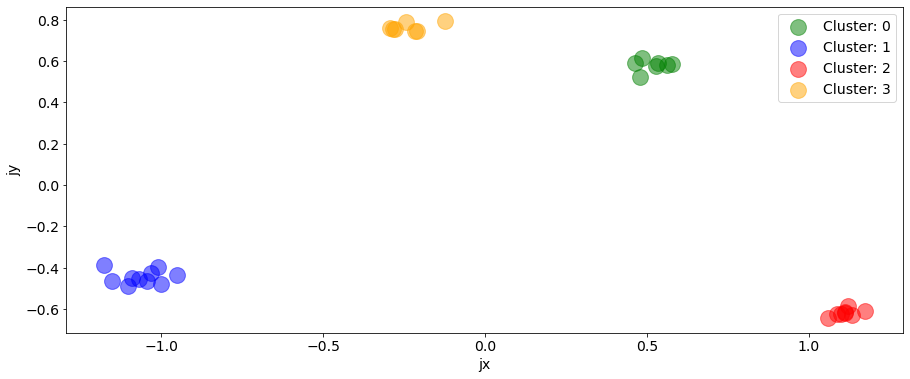

In [15]:
# 将重合数据点进行抖动处理以便观察
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])

# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [16]:
# 打印每个簇内的数据
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 7 observations
     id_resp_p method resp_mime_types  request_body_len
126       8080    GET      text/plain                 0
127       8080    GET      text/plain                 0
128       8080    GET      text/plain                 0
129       8080    GET      text/plain                 0
130       8080    GET      text/plain                 0

Cluster 1: 10 observations
     id_resp_p method resp_mime_types  request_body_len
140         80   POST      text/plain             69823
141         80   POST      text/plain             69993
142         80   POST      text/plain             71993
143         80   POST      text/plain             70993
144         80   POST      text/plain             72993

Cluster 2: 8 observations
     id_resp_p method        resp_mime_types  request_body_len
106         80    GET  application/x-dosexec                 0
107         80    GET  application/x-dosexec                 0
109         80    GET  application/x-dosexec             

#### <div style="float: right; margin: 10px 10px 10px 10px"><img src="images/deep_dive.jpeg" width="250px"></div>
## 各个簇表示的异常的分类
- Cluster 0: 应用程序/x-dosexec mime_types
- Cluster 1: OPTIONS 的 http 方法（而不是普通的 GET/POST）
- Cluster 2: 如下
- Cluster 3: 响应端口 8080（而不是 80）

## 数值变量异常
- Cluster 2: request_body_len 值是异常值（对于此演示数据集）



For this small demo dataset almost all request_body_len are 0
Cluster 2 represents outliers


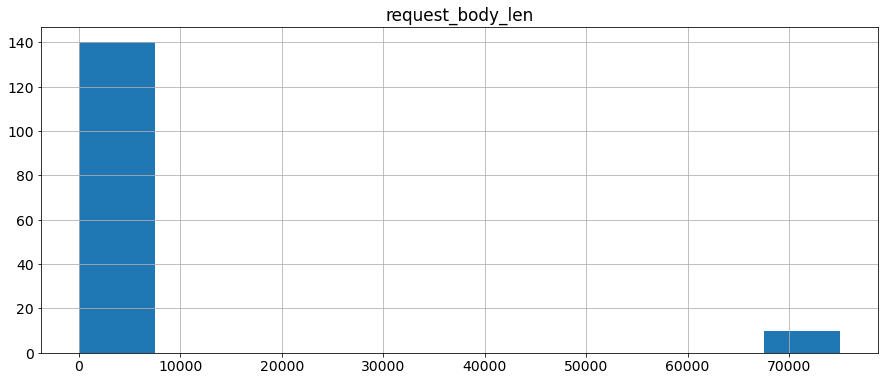

In [17]:
# 分析request长度分布
http_pddf[['request_body_len']].hist()
print('\nFor this small demo dataset almost all request_body_len are 0\nCluster 2 represents outliers')